In [1]:
from ndpyramid import pyramid_reproject
from ndpyramid.core import _multiscales_template, _get_version
import xarray as xr
import rioxarray
import datatree as dt
import fsspec
from numcodecs.zlib import Zlib
import regionmask

In [2]:
def pyramid_reproject(ds, levels: int = None, pixels_per_tile=128) -> dt.DataTree:

    from rasterio.transform import Affine
    from rasterio.warp import Resampling

    # multiscales spec
    save_kwargs = {'levels': levels, 'pixels_per_tile': pixels_per_tile}
    attrs = {
        'multiscales': _multiscales_template(
            datasets=[{'path': str(i) for i in range(levels)}],
            type='reduce',
            method='pyramid_reproject',
            version=_get_version(),
            kwargs=save_kwargs,
        )
    }

    # set up pyramid
    root = xr.Dataset(attrs=attrs)
    pyramid = dt.DataTree(data_objects={"root": root})

    # pyramid data
    for level in range(levels):
        lkey = str(level)
        dim = 2 ** level * pixels_per_tile
        dst_transform = Affine.translation(-20026376.39, 20048966.10) * Affine.scale(
            (20026376.39 * 2) / dim, -(20048966.10 * 2) / dim
        )

        pyramid[lkey] = xr.Dataset(attrs=ds.attrs)
        for k, da in ds.items():
            pyramid[lkey].ds[k] = da.rio.reproject(
                'EPSG:3857',
                resampling=Resampling.average,
                shape=(dim, dim),
                transform=dst_transform,
            )
    #pyramid = pyramid.chunk()
    return pyramid

# let's make some data pyramids

In [91]:
global_path = 's3://carbonplan-climatetrace/v0.4/global/3000m/raster_tot.zarr'
global_raster = xr.open_zarr(global_path, consolidated=True)

In [92]:
# handle datatypes and missing values
global_raster = global_raster.astype('float32')
global_raster = global_raster.fillna(0)

In [93]:
global_raster = global_raster.rio.write_crs('EPSG:4326')

In [94]:
global_raster = global_raster.rename({'lat': 'y', 'lon': 'x'})

In [95]:
global_raster = global_raster.transpose('year', 'y', 'x')

In [96]:
# trim to just land
land = regionmask.defined_regions.natural_earth.land_110
land_mask = land.mask(global_raster.x, global_raster.y).rename({'lat': 'y', 'lon': 'x'})
global_raster = global_raster.where(land_mask==0)

In [100]:
datatree = pyramid_reproject(global_raster, levels=7)
# datatree will include collection of ds, one for each level in pyramid
# print(str(datatree)) will show you the full datatree structure

In [103]:
for key in datatree.children:
    key.ds = key.ds.chunk({'x': 128, 'y': 128, 'year': -1})
    key.ds.emissions.attrs = {'_FillValue': -999}
    key.ds['emissions'] = key.ds.emissions.where(key.ds.emissions < 1e38)
    key.ds.emissions.encoding['compressor'] = Zlib()

In [105]:
encoding = {"emissions": {"compressor": Zlib()}}

In [106]:
mapper = fsspec.get_mapper('s3://carbonplan-scratch/junk/v0_emissions_pyramids.zarr')
datatree.to_zarr(mapper, consolidated=True, mode='w', encoding=encoding)

# and now let's make the 1 degree raster

In [12]:
one_degree_raster = global_raster.coarsen(y=40, x=40).sum().compute().drop('spatial_ref')

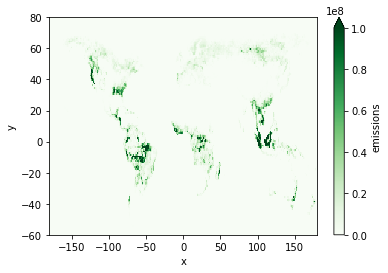

In [13]:
one_degree_raster.sum(dim='year').emissions.plot(cmap='Greens', vmax=1e8)

In [15]:
one_degree_raster = one_degree_raster.chunk({'x': -1, 'y': -1, 'year': -1}).astype('float32')

In [16]:
mapper = fsspec.get_mapper('s3://carbonplan-scratch/junk/v0_one_degree_raster.zarr')

In [17]:
one_degree_raster.to_zarr(mapper, consolidated=True, mode='w', encoding=encoding)